In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install torch
!pip install torch-geometric
!pip install torchtext
!pip install joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 82.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.2 MB/s eta 0:00:00


In [2]:
import spacy
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

In [4]:
label_dict = {'CG':1, 'OR': 0}

dataset = pd.read_csv('/kaggle/input/fake-review-dataset/fake reviews dataset.csv')
texts = dataset['text_'].values
labels = dataset['label'].map(label_dict).values

<Axes: >

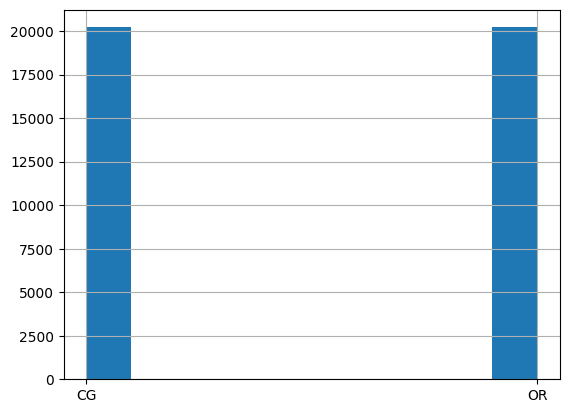

In [5]:
dataset['label'].hist()

In [6]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42, shuffle=True)
print(r'Train Data size: {}'.format(len(train_texts)))
print(r'Test Data size: {}'.format(len(test_texts)))

Train Data size: 32345
Test Data size: 8087


In [7]:
tokenizer = get_tokenizer('basic_english')
def get_tokens(data_it):
    for text in data_it:
        yield tokenizer(text)
        
pad_token = '<pad>'
vocab = build_vocab_from_iterator(get_tokens(train_texts), specials=['<unk>', pad_token])
vocab.set_default_index(vocab["<unk>"])

pad_id_value = vocab[pad_token]
max_len = 100
batch_size = 32

In [8]:
def pad_text(sequence, max_len, pad_value):
    if len(sequence)<max_len:
        sequence += [pad_value] * (max_len - len(sequence))
        
    return sequence


def trunc_text(sequence, max_len):
    if len(sequence)>max_len:
        sequence = sequence[:max_len]
        
    return sequence

def encode_to_tokens(text):
    encoded_text = [vocab[token] for token in tokenizer(text)]
    encoded_text = pad_text(encoded_text, max_len, pad_id_value)
    encoded_text = trunc_text(encoded_text, max_len)
    return encoded_text

In [ ]:
def creat_graph_data(text, label):
    doc = nlp(text)
    x = torch.tensor(encode_to_tokens(text), dtype=torch.long)
    edges = []
    for token in doc:
        if token.head != token and token.head.i<max_len and token.i<max_len:
            edges.append([token.head.i, token.i])
            edges.append([token.i, token.head.i])
            
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    y = torch.tensor([label], dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)


# Parallel processing of the data
def process_data(text, label):
    return creat_graph_data(text, label)

# Process training data in parallel
train_graphs = Parallel(n_jobs=1)(delayed(process_data)(text, label) for text, label in tqdm(zip(train_texts, train_labels), total=len(train_texts)))

# Process test data in parallel
test_graphs = Parallel(n_jobs=1)(delayed(process_data)(text, label) for text, label in tqdm(zip(test_texts, test_labels), total=len(test_texts)))


train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

 73%|███████▎  | 5875/8087 [01:33<00:37, 58.96it/s]

In [95]:
class GCN(torch.nn.Module):
    def __init__(self, vocab_size, max_len, hidden_size):
        super(GCN, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, hidden_size)
        self.conv1 = GCNConv(hidden_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)        
        self.fc1 = torch.nn.Linear(hidden_size, 2)
        self.max_len = max_len
        self.hidden_size = hidden_size
        
    def forward(self, data):
        x, edge_index,bs = data.x, data.edge_index, data.batch_size
        x = self.embedding(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        print(x.shape, bs)
        x = x.reshape(bs, self.max_len, self.hidden_size)
        x = torch.mean(x, dim=1)
        x = self.fc1(x)
        return x

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(len(vocab), max_len, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for i, data in enumerate(train_loader):
        data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    return total_loss/len(train_loader)

def test():
    model.eval()
    total_correct = 0
    total_loss = 0
    for i, data in enumerate(test_loader):
        data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        loss = F.cross_entropy(out, data.y)
        total_loss += loss.item()
        total_correct += int((pred==data.y).sum())
        
    return total_correct/len(test_loader.dataset), total_loss/len(test_loader)
        
Epochs = 10
for i in range(Epochs):
    train_loss = train()
    test_acc, test_loss = test()
    print(f'Epoch: {i+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    

Epoch: 1, Train Loss: 0.2710, Test Loss: 0.2063, Test Acc: 0.9169
Epoch: 2, Train Loss: 0.1502, Test Loss: 0.2133, Test Acc: 0.9183
Epoch: 3, Train Loss: 0.1061, Test Loss: 0.2317, Test Acc: 0.9167
Epoch: 4, Train Loss: 0.0802, Test Loss: 0.2696, Test Acc: 0.9078
Epoch: 5, Train Loss: 0.0649, Test Loss: 0.3124, Test Acc: 0.9102
Epoch: 6, Train Loss: 0.0496, Test Loss: 0.3400, Test Acc: 0.9017
Epoch: 7, Train Loss: 0.0439, Test Loss: 0.3968, Test Acc: 0.9101
Epoch: 8, Train Loss: 0.0338, Test Loss: 0.4559, Test Acc: 0.9060
Epoch: 9, Train Loss: 0.0276, Test Loss: 0.6763, Test Acc: 0.8883
Epoch: 10, Train Loss: 0.0268, Test Loss: 0.5145, Test Acc: 0.9076


In [34]:
model.eval()
pred_list = []
actual_list = []
for i, data in enumerate(test_loader):
    data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    pred_list += list(pred.cpu().numpy())
    actual_list += list(data.y.cpu().numpy())

F1 Score: 0.91


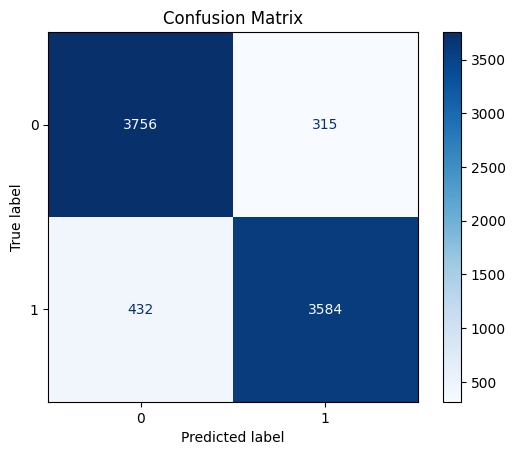

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

cm = confusion_matrix(actual_list, pred_list)
f1 = f1_score(actual_list, pred_list)

# Print results
# print("Confusion Matrix:")
# print(cm)
print(f"F1 Score: {f1:.2f}")

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [40]:
dataset['text_'][0:10].values

array(['Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty',
       "love it, a great upgrade from the original.  I've had mine for a couple of years",
       'This pillow saved my back. I love the look and feel of this pillow.',
       'Missing information on how to use it, but it is a great product for the price!  I',
       'Very nice set. Good quality. We have had the set for two months now and have not been',
       'I WANTED DIFFERENT FLAVORS BUT THEY ARE NOT.',
       'They are the perfect touch for me and the only thing I wish they had a little more space.',
       'These done fit well and look great.  I love the smoothness of the edges and the extra',
       "Great big numbers & easy to read, the only thing I didn't like is the size of the",
       'My son loves this comforter and it is very well made.  We also have a baby'],
      dtype=object)

In [44]:
def creat_graph_data_input(text):
    doc = nlp(text)
    x = torch.tensor(encode_to_tokens(text), dtype=torch.long)
    edges = []
    for token in doc:
        if token.head != token and token.head.i<max_len and token.i<max_len:
            edges.append([token.head.i, token.i])
            edges.append([token.i, token.head.i])
            
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index)

# Parallel processing of the data
def process_data_input(text):
    return creat_graph_data_input(text)

sample_text = texts[2]
input_texts = [sample_text]
input_graphs = Parallel(n_jobs=1)(delayed(process_data_input)(text) for text in input_texts)
input_loader = DataLoader(input_graphs, batch_size=1, shuffle=False)

model.eval()
input_pred_list = []
for i, data in enumerate(input_loader):
    data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    input_pred_list += list(pred.cpu().numpy())

print("Predicted label for the given text: ", input_pred_list[0])

Predicted label for the given text:  1


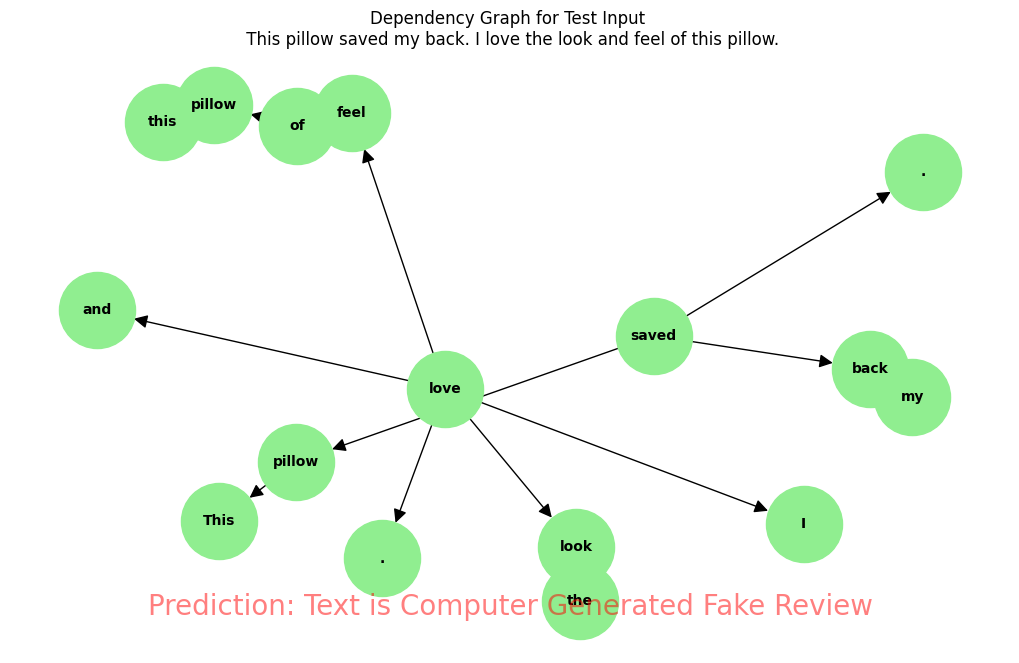

In [117]:
import networkx as nx
doc = nlp(sample_text)

# Create a graph using NetworkX
G = nx.DiGraph()

# Add nodes and edges based on the dependency parsing
for token in doc:
    G.add_node(token.i, label=token.text)
    if token.head != token:  # token.head == token means this token is the root of the sentence
        G.add_edge(token.head.i, token.i)

# Define node labels
labels = {node: data['label'] for node, data in G.nodes(data=True)}

# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color="lightgreen", font_size=10, font_weight="bold", arrows=True, arrowstyle='-|>', arrowsize=20)
plt.title("Dependency Graph for Test Input \n {}".format(sample_text))
plt.text(0.5, 0.1, "Prediction: Text is Computer Generated Fake Review", ha='center', va='top', fontsize=20, color='red', alpha=0.5, transform=plt.gca().transAxes)
plt.show()
